In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import shutil
from tqdm.notebook import tqdm

In [2]:
from tensorflow.keras.models import load_model

n_hidden = 128
OBSERVE_LENGTH = 10
PREDICT_LENGTH = 5
epochs = 1000

model_name = 'sslstm_epoch_{}_hidden_{}_observe_{}_predict_{}'.format(epochs, n_hidden, OBSERVE_LENGTH, PREDICT_LENGTH)
model_path = '/home/zg2309/model/{}.h5'.format(model_name)
print(model_path)
# load model
model = load_model(model_path)
# summarize model.
model.summary()

/home/zg2309/model/sslstm_epoch_1000_hidden_128_observe_10_predict_5.h5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               55296     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 128)            0         
_________________________________________________

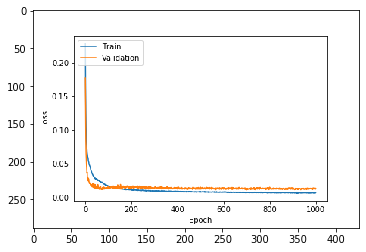

In [3]:
import matplotlib.image as mpimg
img = mpimg.imread('/home/zg2309/history/{}.png'.format(model_name))
plt.imshow(img)
plt.show()

In [11]:
def visualize_trajectory(prediction, gt, folder):
    
    FPS = 10
    DT = 1.0 / FPS
    times = [t * DT for t in range(0, len(gt))]
    
    gtx = gt[:,0]
    predx = prediction[:,0]
    fig1, ax1 = plt.subplots()
    ax1.plot(times, gtx, label='gt')
    
    ax1.plot(times, predx, label="predict")
    
    ax1.set_ylabel('acceleration x')
    ax1.set_xlabel('time')
    fig1.savefig(folder + 'acceleration_x.png')
    
    gty = gt[:,1]
    predy = prediction[:,1]
    fig2, ax2 = plt.subplots()
    ax2.plot(times, gty, label='gt')
    
    ax2.plot(times, predy, label="predict")
    
    ax2.set_ylabel('acceleration y')
    ax2.set_xlabel('time')
    fig2.savefig(folder + 'acceleration_y.png')
    
    plt.close(fig1)
    plt.close(fig2)
    
#     gtz = gt[:,2]
#     predz = prediction[:,2]
#     fig3, ax3 = plt.subplots()
#     ax3.plot(times, gtz, label='gt')
    
#     ax3.plot(times, predz, label="predict")
    
#     ax3.set_ylabel('acceleration z')
#     ax3.set_xlabel('time')
#     fig3.show()

def MAE(predict, label):
    result = np.abs(predict - label)
    result = result.reshape((-1,3))
    return np.mean(result, axis=0)
    
def MSE(predict, label):
    result = (predict - label)**2
    result = result.reshape((-1, 3))
    return np.mean(result, axis=0)

def predict(raw):
    length, _ = raw.shape
    prediction = np.zeros((length, 3))
    prediction[:OBSERVE_LENGTH, :] = raw[:OBSERVE_LENGTH, -3:].copy()
    acceleration = np.zeros((length, 3))
    acceleration[:OBSERVE_LENGTH, :] = raw[:OBSERVE_LENGTH, -3:].copy()
    
    predict_start = OBSERVE_LENGTH
    
    while predict_start < length:
        if predict_start + PREDICT_LENGTH > length:
            predict_start = length - PREDICT_LENGTH
            
        test_X = np.zeros((1,OBSERVE_LENGTH,dim_input))
        
        #load feats
        test_X[0, :, :-3] = raw[predict_start - OBSERVE_LENGTH:predict_start, :-3]
        #laod acceleration
        test_X[0, :, -3:] = acceleration[predict_start - OBSERVE_LENGTH:predict_start, :]
        
        
        predict_y = model.predict(test_X)
        prediction[predict_start:predict_start+PREDICT_LENGTH, :] = predict_y.squeeze().copy()
        acceleration[predict_start:predict_start+PREDICT_LENGTH, :] = predict_y.squeeze().copy()
        
        predict_start = predict_start + PREDICT_LENGTH
        
    return prediction

In [12]:
# use gt predicion
BOX_PTS = 9
TEST_FILES = '/home/dataset/team2/validation/validation*/*_smooth_{}.csv'.format(BOX_PTS)

test_csvs = glob.glob(TEST_FILES)
test_num = len(test_csvs)
# print(test_csvs)
print('test csv num:', len(test_csvs))
dim_input = 15

total_mae = []
total_mse = []

predict_path = '/home/zg2309/prediction/{}/'.format(model_name)

if os.path.exists(predict_path):
    shutil.rmtree(predict_path)
os.mkdir(predict_path)

for csv in tqdm(test_csvs):
    raw = pd.read_csv(csv).values
    gt = raw[:,-3:]
    prediction = predict(raw)
    
    tar_name = csv.split('/')[5]
    tar_path = predict_path + tar_name + '/'

    if not os.path.exists(tar_path):
        os.mkdir(tar_path)
        
    seg_name = csv.split('/')[6][:-13]
    
    folder = tar_path + seg_name + '/'
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)
    
    np.save(folder + 'prediction.npy', prediction)
    
    visualize_trajectory(prediction, gt, folder)
    
    mae_x, mae_y, mae_z = MAE(prediction, gt)
    mse_x, mse_y, mse_z = MSE(prediction, gt)

    total_mae.append(np.array([mae_x,mae_y,mae_z]))
    total_mse.append(np.array([mse_x,mse_y,mse_z]))                     

test csv num: 150


In [13]:
# abandon z
total_mae = np.array(total_mae)
total_mse = np.array(total_mse)
print('MAE X Y Z: ', np.mean(total_mae, axis=0))
print('MSE X Y Z: ', np.mean(total_mse, axis=0))

MAE X Y Z:  [0.3514694  0.32181093 0.0440951 ]
MSE X Y Z:  [0.31377743 0.29975836 0.00574004]


In [7]:
prediction.shape

(198, 3)